In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

import pprint
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn import metrics

%matplotlib inline

# Import dataset

In [2]:
df = pd.read_csv("./linked_ratings_fundamentals.csv")

print("Shape of DataFrame at the start of cleaning:", df.shape)

cols_to_drop = ['companyid', 'adate', 'pdate', 'shorttermflag']
df = df.drop(columns=cols_to_drop, errors='ignore')
df = df.dropna()

print("Shape of DataFrame after dropping rows with any missing values:", df.shape)

print("\nData types after processing:")
print(df.dtypes)

display(df.head())

/var/folders/b8/tx0n2hrn1td0rplcz94wqcs40000gn/T/ipykernel_31992/180268445.py:1: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./linked_ratings_fundamentals.csv")


Shape of DataFrame at the start of cleaning: (8277470, 84)
Shape of DataFrame after dropping rows with any missing values: (876714, 81)

Data types after processing:
entity_id         int64
ratingdate       object
ciqcompanyid      int64
entity_pname     object
ratingsymbol     object
                 ...   
staff_sale      float64
accrual         float64
ptb             float64
PEG_trailing    float64
divyield         object
Length: 81, dtype: object


,entity_id,ratingdate,ciqcompanyid,entity_pname,ratingsymbol,outlook,priorratingsymbol,prioroutlook,longtermflag,gvkey,...,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield
12159,100007,2006-08-08,45274156,Aramark Services Inc.,BB+,NM,BBB-,NM,1,144519,...,3.400,8.888,214.227,0.0,0.0,0.0,-0.062,2.586,49.623,.805%
12160,100007,2006-08-08,45274156,Aramark Services Inc.,BB+,NM,BBB-,NM,1,144519,...,3.400,8.888,214.227,0.0,0.0,0.0,-0.062,2.528,48.515,.824%
12161,100007,2006-08-08,45274156,Aramark Services Inc.,BB+,NM,BBB-,NM,1,144519,...,3.400,8.888,214.227,0.0,0.0,0.0,-0.062,2.406,42.480,.865%
12165,100007,2006-08-08,45274156,Aramark Services Inc.,BB+,NM,BBB-,NM,1,144519,...,3.452,8.565,290.102,0.0,0.0,0.0,-0.061,2.481,1.946,.984%
12166,100007,2006-08-08,45274156,Aramark Services Inc.,BB+,NM,BBB-,NM,1,144519,...,3.452,8.565,290.102,0.0,0.0,0.0,-0.061,2.575,2.020,.948%


# Data Preparation

I used two different data sets (ratings and financial ratios) and linked them to get my data set. The ratings had annual ratings while the financial ratios data set gave quarterly reports.

To clean up the data, I converted all date columns to `datetime`, and for each rating, I kept only the most recent financial data published BEFORE the rating date to prevent look-ahead bias (using future financial data to predict ratings). I made sure to remove any duplicate data entries and keep the most recent financial data.

I also mapped `ratingsymbol` and `priorratingsymbol`, which was originally of data type `object` (Alphabetical rating string) using ordinal encoding such that the higher the number, the higher the rank.

`outlook` and `prioroutlook` are categorical: Developing, Negative, NM (Not Meaningful), NR (Not Rated), Positive, Stable. I used one-hot encoding to represent them.

I then removed irrelevant identifier variables that are not meaningful to modeling.

In [3]:
sample = df[(df['entity_id'] == 100009) & (df['ratingdate'] == '2019-03-18')]
print(f"\nABT on 3/18/19 originally has {len(sample)} row(s)")
if len(sample) > 0:
    print(f"Using financial data from: {sample['qdate'].iloc[0]} (published: {sample['public_date'].iloc[0]})\n")

df['ratingdate'] = pd.to_datetime(df['ratingdate'])
df['qdate'] = pd.to_datetime(df['qdate'])  # Quarterly report date
df['public_date'] = pd.to_datetime(df['public_date'])  # Publication date

df_clean = df[df['public_date'] <= df['ratingdate']]

df_clean = df_clean.sort_values(['entity_id', 'ratingdate', 'public_date'], ascending=[True, True, False])
df_clean = df_clean.drop_duplicates(subset=['entity_id', 'ratingdate'], keep='first')

df_clean['divyield'] = (
    df_clean['divyield']
    .astype(str)
    .str.replace('%', '', regex=False)
    .astype(float)
)

rating_map = {
    'AAA': 11, 'AA+': 11, 'AA': 11, 'AA-': 11, 'A+': 11,
    'A': 11, 'A-': 10, 'BBB+': 9, 'BBB': 8, 'BBB-': 7,
    'BB+': 6, 'BB': 5, 'BB-': 4, 'B+': 3, 'B': 2, 'B-': 1,
    'CCC': 1, 'CC': 1, 'C': 1, 'D': 1
}

df_clean['Rating_Ordinal'] = df_clean['ratingsymbol'].map(rating_map)
df_clean['Prior_Rating_Ordinal'] = df_clean['priorratingsymbol'].map(rating_map)

df_clean = df_clean.dropna(subset=['Rating_Ordinal'])

print(f"Original rows: {len(df)}")
print(f"After deduplication and dropping rows with missing Rating_Ordinal: {len(df_clean)}")
print(f"Rows removed: {len(df) - len(df_clean)}")

# Verify: Check ABT on 3/18/19 again
sample_clean = df_clean[(df_clean['entity_id'] == 100009) & (df_clean['ratingdate'] == '2019-03-18')]
print(f"\nABT on 3/18/19 now has {len(sample_clean)} row(s)")
if len(sample_clean) > 0:
    print(f"Using financial data from: {sample_clean['qdate'].iloc[0]} (published: {sample_clean['public_date'].iloc[0]})")

print(df_clean.shape)


ABT on 3/18/19 originally has 350 row(s)
Using financial data from: 2004-09-30 (published: 2005-01-31)

Original rows: 876714
After deduplication and dropping rows with missing Rating_Ordinal: 2080
Rows removed: 874634

ABT on 3/18/19 now has 1 row(s)
Using financial data from: 2018-12-31 00:00:00 (published: 2019-02-28 00:00:00)
(2080, 83)


This narrowed down our dataset greatly to (2080, 83)

In [4]:
drop_list = [
    'entity_id', 'ciqcompanyid',
    'priorratingsymbol', 'qdate', 'public_date', 'entity_pname',
    'gvkey', 'longtermflag'
]

df_clean = df_clean.drop(columns=drop_list, errors='ignore')
display(df_clean.head())


,ratingdate,ratingsymbol,outlook,prioroutlook,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,...,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,Rating_Ordinal,Prior_Rating_Ordinal
12170,2006-08-08,BB+,NM,NM,15.309,0.267,7.438,19.693,19.938,18.994,...,274.023,0.0,0.0,0.0,-0.060,2.754,1.508,0.872,6.0,7.0
12221,2007-01-09,B+,Negative,NM,15.975,0.245,7.831,21.429,21.708,22.287,...,202.407,0.0,0.0,0.0,-0.062,2.832,2.859,0.838,3.0,6.0
12557,2013-12-12,BB,Stable,NM,15.975,0.245,7.831,21.429,21.708,22.287,...,202.407,0.0,0.0,0.0,-0.062,2.832,2.859,0.838,5.0,3.0
12653,2017-03-02,BB+,Stable,Positive,15.975,0.245,7.831,21.429,21.708,22.287,...,202.407,0.0,0.0,0.0,-0.062,2.832,2.859,0.838,6.0,5.0
12749,2020-03-24,BB,NM,Negative,15.975,0.245,7.831,21.429,21.708,22.287,...,202.407,0.0,0.0,0.0,-0.062,2.832,2.859,0.838,5.0,6.0


# Feature selection
By removing irrelevant or redundant features, we can reduce overfitting, improve model accuracy, and reduce training time.
I began by removing features with low variance (features that have a similar value in all samples, meaning it wouldnt have a significant impact on the prediction task) which is a simple baseline approach to feature selection. This brought me from 82 features to 51. I plan to later perform feature selection by model type.

In [5]:
# Removing features with low variance

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import pandas as pd

categorical_list = [
    'ratingdate', 'ratingsymbol', 'Rating_Ordinal',
    'Prior_Rating_Ordinal', 'outlook', 'prioroutlook'
]

df_clean_copy = df_clean.copy()

df_numerical = df_clean_copy.drop(columns=categorical_list, errors='ignore')
df_categorical = df_clean_copy[categorical_list]


numerical_scaled = StandardScaler().fit_transform(df_numerical)

sel = VarianceThreshold(threshold=0.01)
sel.fit(numerical_scaled)
selected_numerical_cols = sel.get_feature_names_out(df_numerical.columns)

df_scaled_numerical = pd.DataFrame(
    numerical_scaled[:, sel.get_support()],
    columns=selected_numerical_cols,
    index=df_numerical.index
)

df_clean = pd.concat([df_scaled_numerical, df_categorical], axis=1)

display(df_clean)

display(df_clean.dtypes)

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,accrual,ptb,PEG_trailing,divyield,ratingdate,ratingsymbol,Rating_Ordinal,Prior_Rating_Ordinal,outlook,prioroutlook
12170,0.013081,-0.761318,-0.401976,0.046728,0.046164,-0.013219,-0.036698,-0.603116,-0.232524,-0.172621,...,-0.234789,-0.088824,-0.219184,-0.842329,2006-08-08,BB+,6.0,7.0,NM,NM
12221,0.013655,-0.809449,-0.342990,0.055238,0.054818,0.013658,-0.002791,-0.593718,-0.205159,-0.163130,...,-0.258699,-0.074906,-0.105623,-0.857806,2007-01-09,B+,3.0,6.0,Negative,NM
12557,0.013655,-0.809449,-0.342990,0.055238,0.054818,0.013658,-0.002791,-0.593718,-0.205159,-0.163130,...,-0.258699,-0.074906,-0.105623,-0.857806,2013-12-12,BB,5.0,3.0,Stable,NM
12653,0.013655,-0.809449,-0.342990,0.055238,0.054818,0.013658,-0.002791,-0.593718,-0.205159,-0.163130,...,-0.258699,-0.074906,-0.105623,-0.857806,2017-03-02,BB+,6.0,5.0,Stable,Positive
12749,0.013655,-0.809449,-0.342990,0.055238,0.054818,0.013658,-0.002791,-0.593718,-0.205159,-0.163130,...,-0.258699,-0.074906,-0.105623,-0.857806,2020-03-24,BB,5.0,6.0,NM,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8244563,0.029061,-0.555668,-0.047462,0.044389,0.043342,0.013984,-0.002379,0.033783,-0.099188,-0.155334,...,-0.294564,0.041078,-0.305258,-0.838688,2024-11-18,BB-,4.0,3.0,Stable,Stable
8266054,0.013339,0.271309,0.272080,0.034349,0.032620,-0.028832,-0.056395,-0.046383,0.094285,-0.112623,...,0.386870,-0.377179,-0.154124,-0.378953,2023-07-28,BB,5.0,5.0,NM,Stable
8268130,0.024083,-0.509725,0.794546,0.113650,0.111712,0.105174,0.164590,0.080776,0.233494,-0.106522,...,-0.139149,0.004320,0.158064,-0.706685,2024-02-06,B+,3.0,4.0,Stable,Stable
8268610,0.024083,-0.509725,0.794546,0.113650,0.111712,0.105174,0.164590,0.080776,0.233494,-0.106522,...,-0.139149,0.004320,0.158064,-0.706685,2024-06-11,B,2.0,3.0,Negative,Stable


CAPEI                   float64
bm                      float64
evm                     float64
pe_op_basic             float64
pe_op_dil               float64
                         ...   
ratingsymbol             object
Rating_Ordinal          float64
Prior_Rating_Ordinal    float64
outlook                  object
prioroutlook             object
Length: 75, dtype: object

In [6]:
import numpy as np
variances = np.var(df_clean.select_dtypes(include=[np.number]), axis=0)
print(np.sort(variances))

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         8.02164935 8.82918801]


# Training / Testing Data Split
I used an 80:20 split on my dataset. I wanted to split my data by time (use older data to predict newer ratings), so I sorted the dataframe chronologically based on the `ratingdate` column.

However, one concern I had was what if the rating methodology changed over time. Using the 80:20 split, my training data was from 2005-02-04 to 2020-10-20 and my testing data was from 2020-10-20 to 2024-12-31. What if the rating conventions changed due to COVID?

In order to address this issue, I performed EDA on around 30% of my testing data(from 2020-10-20 to 2021-10-20). If the distribution of ratings were similar for the training and testing data, I would be able to ignore this issue.

In [7]:
df_clean_filtered = df_clean.sort_values(by='ratingdate', ascending=True)
print(df_clean_filtered['ratingdate'].dtype)

df_clean_filtered = df_clean_filtered.sort_values(by='ratingdate', ascending=True)

min_date = df_clean_filtered['ratingdate'].min()
max_date = df_clean_filtered['ratingdate'].max()
print(f"Rating date range: {min_date} to {max_date}")

split_percentage = 0.8

split_index = int(len(df_clean_filtered) * split_percentage)

split_date = df_clean_filtered.iloc[split_index]['ratingdate']

print(f"Using a {split_percentage*100}% split for training.")
print(f"Split point index: {split_index}")
print(f"Approximate split date: {split_date}")

datetime64[ns]
Rating date range: 2005-02-04 00:00:00 to 2024-12-31 00:00:00
Using a 80.0% split for training.
Split point index: 1664
Approximate split date: 2020-10-20 00:00:00


In [17]:
display(df_clean_filtered)

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,accrual,ptb,PEG_trailing,divyield,ratingdate,ratingsymbol,Rating_Ordinal,Prior_Rating_Ordinal,outlook,prioroutlook
4596946,0.056262,-1.063230,1.464250,0.121646,0.124059,0.206582,0.240599,1.865420,1.211368,-0.199739,...,0.279275,0.828165,1.122953,-1.155951,2005-02-04,A,11.0,10.0,Positive,Stable
4116575,0.026531,-0.223127,-0.885117,-0.039520,-0.039716,-0.149607,-0.208763,-0.237673,-0.170346,-0.216009,...,0.422735,-0.248525,-0.344597,-0.756755,2005-02-04,BB,5.0,4.0,Stable,Positive
2551234,0.026588,-0.877270,-0.070576,0.014818,0.014347,-0.058622,-0.093977,-0.427306,-0.089399,-0.132961,...,-0.712988,0.214876,-0.254235,-0.866909,2005-02-15,BBB,8.0,7.0,Stable,Positive
1292063,0.024900,0.647605,-0.596043,0.041943,0.045909,-0.135178,-0.190559,-0.055781,0.058493,-0.213297,...,1.391088,-0.354696,-0.329130,0.322030,2005-02-16,BBB,8.0,7.0,Stable,Stable
2925646,0.032616,0.000025,-0.573980,0.020034,0.019799,-0.058899,-0.094327,-0.046935,-0.004665,-0.168892,...,-0.306519,0.012171,-0.278696,-0.401712,2005-03-01,BBB,8.0,9.0,Stable,NM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861191,0.007371,0.809500,2.675180,-0.093971,-0.095202,-0.220719,-0.298477,0.263774,-0.046670,0.398205,...,-1.095548,-0.394309,-0.348211,-0.292468,2024-12-10,BBB,8.0,9.0,Stable,Negative
3838537,0.005015,0.032842,-0.591390,-0.028446,-0.029746,-0.132223,-0.186832,-0.688257,-0.398206,-0.159740,...,0.016266,-0.440524,-0.343588,1.965241,2024-12-19,BB-,4.0,5.0,Negative,Negative
3542930,-0.074032,-0.971344,-0.824631,-0.022141,-0.023722,-0.120748,-0.172087,0.570613,-0.234099,0.433797,...,1.056349,0.465402,-0.338797,-0.069428,2024-12-23,D,1.0,1.0,NM,NM
1145709,0.045948,-0.791947,-0.481224,0.020647,0.019858,-0.060482,-0.096325,-0.655638,-0.267550,-0.073303,...,-0.067419,0.121732,-0.345773,0.285615,2024-12-26,BB,5.0,6.0,Stable,Negative


In [9]:
import pandas as pd

end_date_eda = '2021-10-20'
df_train = df_clean_filtered.iloc[:split_index].copy()
df_test = df_clean_filtered[(df_clean_filtered['ratingdate'] >= end_date_eda)].copy()

drop_list = [
    'ratingdate', 'ratingsymbol', 'Rating_Ordinal'
]

X_test = df_test.drop(columns=drop_list, errors='ignore')
y_test = df_test['Rating_Ordinal']

X_train = df_train.drop(columns=drop_list, errors='ignore')
y_train = df_train['Rating_Ordinal']

print("Shape of training features (X_train):", X_train.shape)
print("Shape of training target (y_train):", y_train.shape)
print("Shape of testing features (X_test):", X_test.shape)
print("Shape of testing target (y_test):", y_test.shape)

display(X_train.head())
display(y_train.head())

Shape of training features (X_train): (1664, 72)
Shape of training target (y_train): (1664,)
Shape of testing features (X_test): (290, 72)
Shape of testing target (y_test): (290,)


,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,Prior_Rating_Ordinal,outlook,prioroutlook
4596946,0.056262,-1.063230,1.464250,0.121646,0.124059,0.206582,0.240599,1.865420,1.211368,-0.199739,...,1.702215,-0.476795,-0.22059,0.279275,0.828165,1.122953,-1.155951,10.0,Positive,Stable
4116575,0.026531,-0.223127,-0.885117,-0.039520,-0.039716,-0.149607,-0.208763,-0.237673,-0.170346,-0.216009,...,-0.418745,-0.476795,-0.22059,0.422735,-0.248525,-0.344597,-0.756755,4.0,Stable,Positive
2551234,0.026588,-0.877270,-0.070576,0.014818,0.014347,-0.058622,-0.093977,-0.427306,-0.089399,-0.132961,...,-0.418745,0.600916,-0.22059,-0.712988,0.214876,-0.254235,-0.866909,7.0,Stable,Positive
1292063,0.024900,0.647605,-0.596043,0.041943,0.045909,-0.135178,-0.190559,-0.055781,0.058493,-0.213297,...,-0.418745,-0.476795,-0.22059,1.391088,-0.354696,-0.329130,0.322030,7.0,Stable,Stable
2925646,0.032616,0.000025,-0.573980,0.020034,0.019799,-0.058899,-0.094327,-0.046935,-0.004665,-0.168892,...,-0.418745,5.350828,-0.22059,-0.306519,0.012171,-0.278696,-0.401712,9.0,Stable,NM


4596946    11.0
4116575     5.0
2551234     8.0
1292063     8.0
2925646     8.0
Name: Rating_Ordinal, dtype: float64

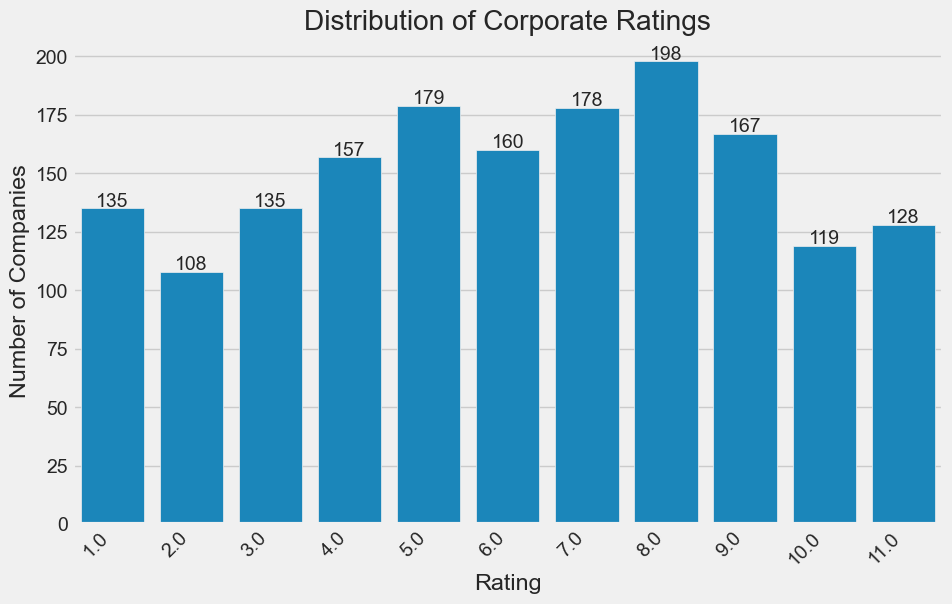

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a style for the plots
sns.set_style("whitegrid")
plt.style.use('fivethirtyeight')

merged_rating_order = [
    'Above A', 'A-', 'BBB+', 'BBB', 'BBB-',
    'BB+', 'BB', 'BB-', 'B+', 'B', 'Below B-'
]
plt.figure(figsize=(10, 6))
# Using df_clean for plotting
ax = sns.countplot(x='Rating_Ordinal', data=df_train)
plt.title('Distribution of Corporate Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Companies')

# Add counts above each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.show()

Shape of df_eda (data from 2020-10-20 to 2021-10-20): (126, 75)


,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,...,accrual,ptb,PEG_trailing,divyield,ratingdate,ratingsymbol,Rating_Ordinal,Prior_Rating_Ordinal,outlook,prioroutlook
4266334,0.021765,-0.969156,-0.372108,0.043625,0.042301,-0.008273,-0.030458,-0.142581,0.059301,-0.158723,...,-0.449979,0.606902,-0.267516,-0.810922,2020-10-20,B,2.0,1.0,Stable,Positive
2283122,0.009748,-0.774445,0.402809,0.000689,-0.000390,-0.083221,-0.125011,-0.065733,-0.230992,-0.161435,...,-0.258699,-0.234964,-0.263986,-0.406264,2020-10-22,BBB-,7.0,8.0,Negative,Negative
5559251,0.016466,-0.759130,0.656312,0.034506,0.033089,-0.019666,-0.055489,-0.372019,0.100073,-0.026525,...,0.303185,0.045182,0.065097,0.244648,2020-10-23,BBB,8.0,8.0,Negative,Stable
7012399,0.006386,-0.767882,0.043943,0.003665,0.002476,-0.055447,-0.089972,1.199772,-0.082377,-0.045168,...,0.064086,0.055710,-0.301559,0.563277,2020-10-27,BBB+,9.0,11.0,Negative,NM
523723,0.026783,0.010964,0.013475,0.063273,0.061986,-0.034365,-0.063376,1.857680,-0.135320,-0.124826,...,-0.210879,-0.307588,-0.303577,-0.447230,2020-10-28,BB,5.0,4.0,Stable,Stable


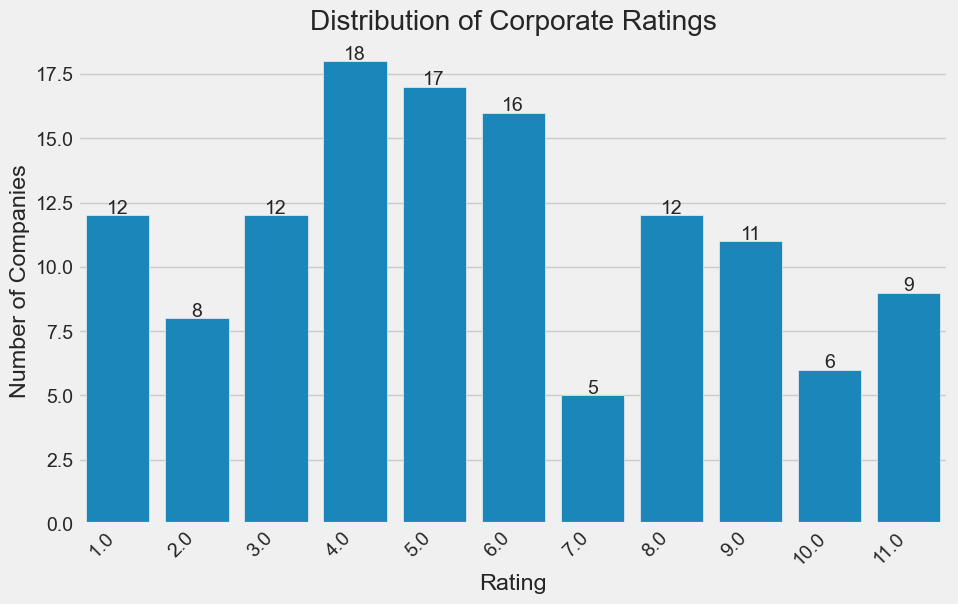

In [11]:
#EDA on 2020-2021 to see if rating trends have changed

start_date_eda = '2020-10-20'
end_date_eda = '2021-10-20'

df_eda = df_clean_filtered[(df_clean_filtered['ratingdate'] >= start_date_eda) & (df_clean_filtered['ratingdate'] <= end_date_eda)].copy()

print(f"Shape of df_eda (data from {start_date_eda} to {end_date_eda}): {df_eda.shape}")
display(df_eda.head())

plt.figure(figsize=(10, 6))

ax = sns.countplot(x='Rating_Ordinal', data=df_eda)
plt.title('Distribution of Corporate Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Companies')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45, ha='right')

plt.show()

# Explanatory Data Analysis
Descriptive statistics and visualization. Note that EDA is performed on training data only

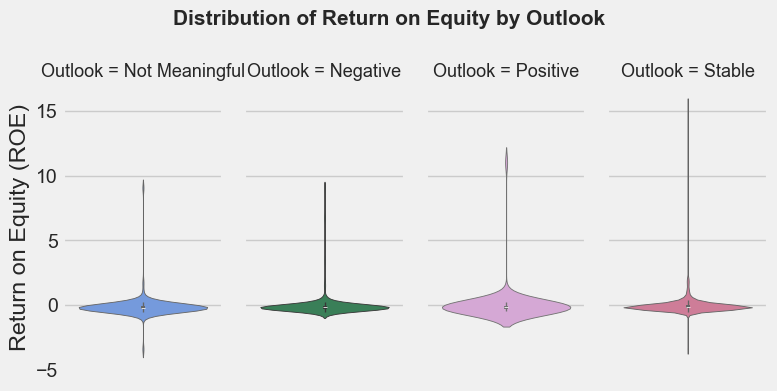

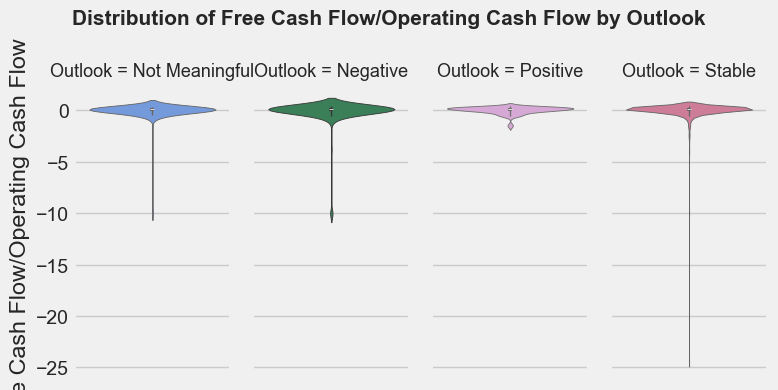

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 4, figsize=(8, 4), sharey=True)

# Outlook = Not Meaningful
sns.violinplot(
    data=X_train[X_train['outlook'] == "NM"],
    y='roe',
    color = 'cornflowerblue',
    inner='box',
    ax=axes[0]
)
axes[0].set_title('Outlook = Not Meaningful', fontsize=13)
axes[0].set_xlabel('')
axes[0].set_ylabel('Return on Equity (ROE)')

# Outlook = Negative
sns.violinplot(
    data=X_train[X_train['outlook'] == "Negative"],
    y='roe',
    color = 'seagreen',
    inner='box',
    ax=axes[1]
)
axes[1].set_title('Outlook = Negative', fontsize=13)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Outlook = Positive
sns.violinplot(
    data=X_train[X_train['outlook'] == "Positive"],
    y='roe',
    color='plum',
    inner='box',
    ax=axes[2]
)
axes[2].set_title('Outlook = Positive', fontsize=13)
axes[2].set_xlabel('')
axes[2].set_ylabel('')

# Outlook = Stable
sns.violinplot(
    data=X_train[X_train['outlook'] == "Stable"],
    y='roe',
    color='palevioletred',
    inner='box',
    ax=axes[3]
)
axes[3].set_title('Outlook = Stable', fontsize=13)
axes[3].set_xlabel('')
axes[3].set_ylabel('')

# Shared title
fig.suptitle('Distribution of Return on Equity by Outlook', fontsize=15, weight='bold')
plt.tight_layout()
plt.show()


fig2, axes2 = plt.subplots(1, 4, figsize=(8, 4), sharey=True)

# Outlook = Not Meaningful
sns.violinplot(
    data=X_train[X_train['outlook'] == "NM"],
    y='fcf_ocf',
    color = 'cornflowerblue',
    inner='box',
    ax=axes2[0]
)
axes2[0].set_title('Outlook = Not Meaningful', fontsize=13)
axes2[0].set_xlabel('')
axes2[0].set_ylabel('Free Cash Flow/Operating Cash Flow')

# Outlook = Negative
sns.violinplot(
    data=X_train[X_train['outlook'] == "Negative"],
    y='fcf_ocf',
    color = 'seagreen',
    inner='box',
    ax=axes2[1]
)
axes2[1].set_title('Outlook = Negative', fontsize=13)
axes2[1].set_xlabel('')
axes2[1].set_ylabel('')

# Outlook = Positive
sns.violinplot(
    data=X_train[X_train['outlook'] == "Positive"],
    y='fcf_ocf',
    color='plum',
    inner='box',
    ax=axes2[2]
)
axes2[2].set_title('Outlook = Positive', fontsize=13)
axes2[2].set_xlabel('')
axes2[2].set_ylabel('')

# Outlook = Stable
sns.violinplot(
    data=X_train[X_train['outlook'] == "Stable"],
    y='fcf_ocf',
    color='palevioletred',
    inner='box',
    ax=axes2[3]
)
axes2[3].set_title('Outlook = Stable', fontsize=13)
axes2[3].set_xlabel('')
axes2[3].set_ylabel('')

# Shared title
fig2.suptitle('Distribution of Free Cash Flow/Operating Cash Flow by Outlook', fontsize=15, weight='bold')
plt.tight_layout()
plt.show()



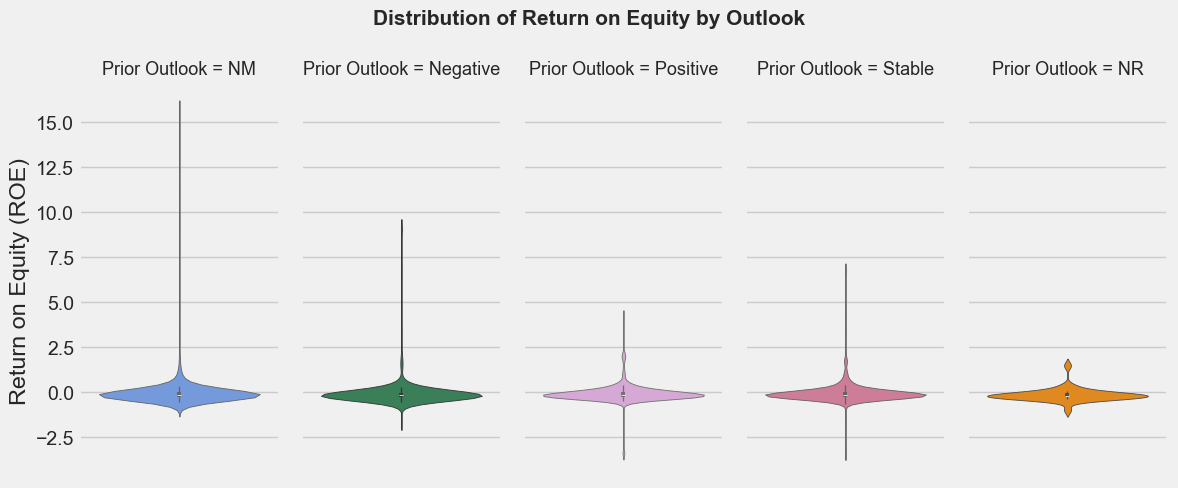

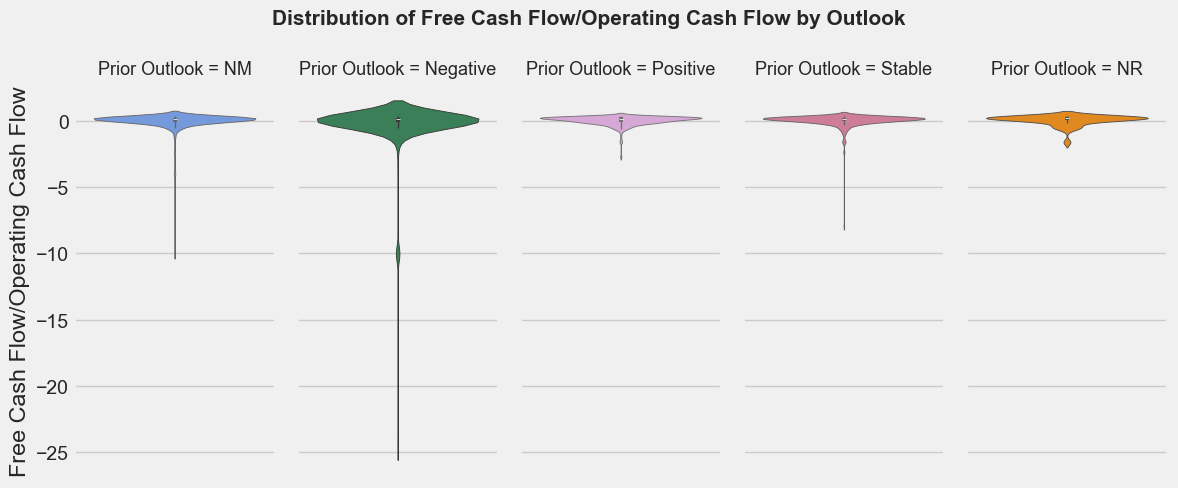

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 5, figsize=(12, 5), sharey=True)

# Prior Outlook = Not Meaningful
sns.violinplot(
    data=X_train[X_train['prioroutlook'] == "NM"],
    y='roe',
    color = 'cornflowerblue',
    inner='box',
    ax=axes[0]
)
axes[0].set_title('Prior Outlook = NM', fontsize=13)
axes[0].set_xlabel('')
axes[0].set_ylabel('Return on Equity (ROE)')

# Prior Outlook = Negative
sns.violinplot(
    data=X_train[X_train['prioroutlook'] == "Negative"],
    y='roe',
    color = 'seagreen',
    inner='box',
    ax=axes[1]
)
axes[1].set_title('Prior Outlook = Negative', fontsize=13)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Prior Outlook = Positive
sns.violinplot(
    data=X_train[X_train['prioroutlook'] == "Positive"],
    y='roe',
    color='plum',
    inner='box',
    ax=axes[2]
)
axes[2].set_title('Prior Outlook = Positive', fontsize=13)
axes[2].set_xlabel('')
axes[2].set_ylabel('')

# Prior Outlook = Stable
sns.violinplot(
    data=X_train[X_train['prioroutlook'] == "Stable"],
    y='roe',
    color='palevioletred',
    inner='box',
    ax=axes[3]
)
axes[3].set_title('Prior Outlook = Stable', fontsize=13)
axes[3].set_xlabel('')
axes[3].set_ylabel('')

# Prior Outlook = NR
sns.violinplot(
    data=X_train[X_train['prioroutlook'] == "NR"],
    y='roe',
    color='darkorange',
    inner='box',
    ax=axes[4]
)
axes[4].set_title('Prior Outlook = NR', fontsize=13)
axes[4].set_xlabel('')
axes[4].set_ylabel('')

# Shared title
fig.suptitle('Distribution of Return on Equity by Outlook', fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(1, 5, figsize=(12, 5), sharey=True)

# Prior Outlook = Not Meaningful
sns.violinplot(
    data=X_train[X_train['prioroutlook'] == "NM"],
    y='fcf_ocf',
    color = 'cornflowerblue',
    inner='box',
    ax=axes2[0]
)
axes2[0].set_title('Prior Outlook = NM', fontsize=13)
axes2[0].set_xlabel('')
axes2[0].set_ylabel('Free Cash Flow/Operating Cash Flow')

# Prior Outlook = Negative
sns.violinplot(
    data=X_train[X_train['prioroutlook'] == "Negative"],
    y='fcf_ocf',
    color = 'seagreen',
    inner='box',
    ax=axes2[1]
)
axes2[1].set_title('Prior Outlook = Negative', fontsize=13)
axes2[1].set_xlabel('')
axes2[1].set_ylabel('')

# Prior Outlook = Positive
sns.violinplot(
    data=X_train[X_train['prioroutlook'] == "Positive"],
    y='fcf_ocf',
    color='plum',
    inner='box',
    ax=axes2[2]
)
axes2[2].set_title('Prior Outlook = Positive', fontsize=13)
axes2[2].set_xlabel('')
axes2[2].set_ylabel('')

# Prior Outlook = Stable
sns.violinplot(
    data=X_train[X_train['prioroutlook'] == "Stable"],
    y='fcf_ocf',
    color='palevioletred',
    inner='box',
    ax=axes2[3]
)
axes2[3].set_title('Prior Outlook = Stable', fontsize=13)
axes2[3].set_xlabel('')
axes2[3].set_ylabel('')

# Prior Outlook = NR
sns.violinplot(
    data=X_train[X_train['prioroutlook'] == "NR"],
    y='fcf_ocf',
    color='darkorange',
    inner='box',
    ax=axes2[4]
)
axes2[4].set_title('Prior Outlook = NR', fontsize=13)
axes2[4].set_xlabel('')
axes2[4].set_ylabel('')

# Shared title
fig2.suptitle('Distribution of Free Cash Flow/Operating Cash Flow by Outlook', fontsize=15, weight='bold')
plt.tight_layout()
plt.show()



# Analysis of variables

In [14]:
numeric_X = X_train.select_dtypes(include=[np.number])
correlations = X_train.select_dtypes(include=[np.number]).corrwith(
    y_train, method='spearman'
)
correlations.sort_values(ascending=False).head(10)

Prior_Rating_Ordinal    0.905579
ps                      0.416754
ptpm                    0.391252
npm                     0.383307
intcov                  0.382286
intcov_ratio            0.366546
opmad                   0.354248
cfm                     0.329550
opmbd                   0.314637
ptb                     0.300709
dtype: float64

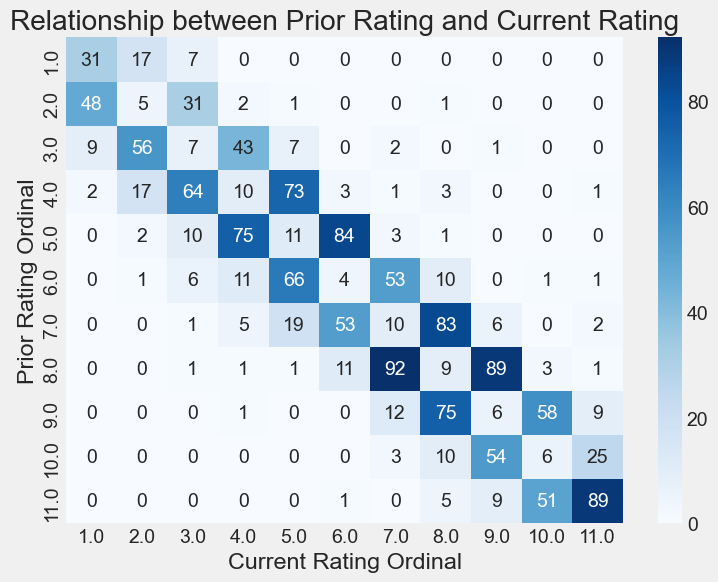

In [15]:
# Create contingency table
ct = pd.crosstab(X_train['Prior_Rating_Ordinal'], y_train)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')

plt.title('Relationship between Prior Rating and Current Rating')
plt.ylabel('Prior Rating Ordinal')
plt.xlabel('Current Rating Ordinal')

plt.show()


# Export Data

In [16]:
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)